In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data = pd.read_excel('/Users/pein/Desktop/12月份和1月份部分平衡样本.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20723 entries, 0 to 20722
Data columns (total 17 columns):
uid                   20723 non-null int64
provinceId            20723 non-null int64
gender                20723 non-null int64
birthYear             20723 non-null int64
createOn              20723 non-null int64
orderNum              20723 non-null int64
Finaltime             20723 non-null int64
totalFee              20723 non-null float64
SingtotalFee          20723 non-null float64
jude_value            20723 non-null float64
register_channelId    20723 non-null int64
cunpon_use            20723 non-null int64
jifen_use             20723 non-null int64
cancel_order          20723 non-null int64
GoodsView             20723 non-null int64
ActiveDays            20723 non-null int64
Loss_or_not           20723 non-null int64
dtypes: float64(3), int64(14)
memory usage: 2.7 MB


In [3]:
data_shuffle = data.sample(frac=1) # 数据的随机化
data_shuffle['provinceId'] = data_shuffle.provinceId.astype('category')
data_shuffle = data_shuffle.drop(['uid'],1)

In [4]:
data_shuffle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20723 entries, 1183 to 6261
Data columns (total 16 columns):
provinceId            20723 non-null category
gender                20723 non-null int64
birthYear             20723 non-null int64
createOn              20723 non-null int64
orderNum              20723 non-null int64
Finaltime             20723 non-null int64
totalFee              20723 non-null float64
SingtotalFee          20723 non-null float64
jude_value            20723 non-null float64
register_channelId    20723 non-null int64
cunpon_use            20723 non-null int64
jifen_use             20723 non-null int64
cancel_order          20723 non-null int64
GoodsView             20723 non-null int64
ActiveDays            20723 non-null int64
Loss_or_not           20723 non-null int64
dtypes: category(1), float64(3), int64(12)
memory usage: 2.5 MB


In [5]:
# 处理年龄
data_shuffle['Age'] = 2017-data_shuffle.birthYear
mask_age_lower = data_shuffle.Age < 10
mask_age_high = data_shuffle.Age > 90
data_shuffle['Age_right'] = 1
data_shuffle.loc[(mask_age_lower),'Age_right'] = 0
data_shuffle.loc[(mask_age_high),'Age_right'] = 0

In [6]:
age_mean = data_shuffle.groupby(['Age_right'])['Age'].describe()

In [7]:
lower_count = mask_age_lower.count()
hig_count = mask_age_lower.count()

In [8]:
### replace the outliers age with 30
data_shuffle.loc[(mask_age_lower),'Age'] = np.random.normal(30,10,(lower_count,1))
data_shuffle.loc[(mask_age_high),'Age'] = np.random.normal(30,10,(hig_count,1))

In [9]:
data_shuffle = data_shuffle.drop(['birthYear'],1)

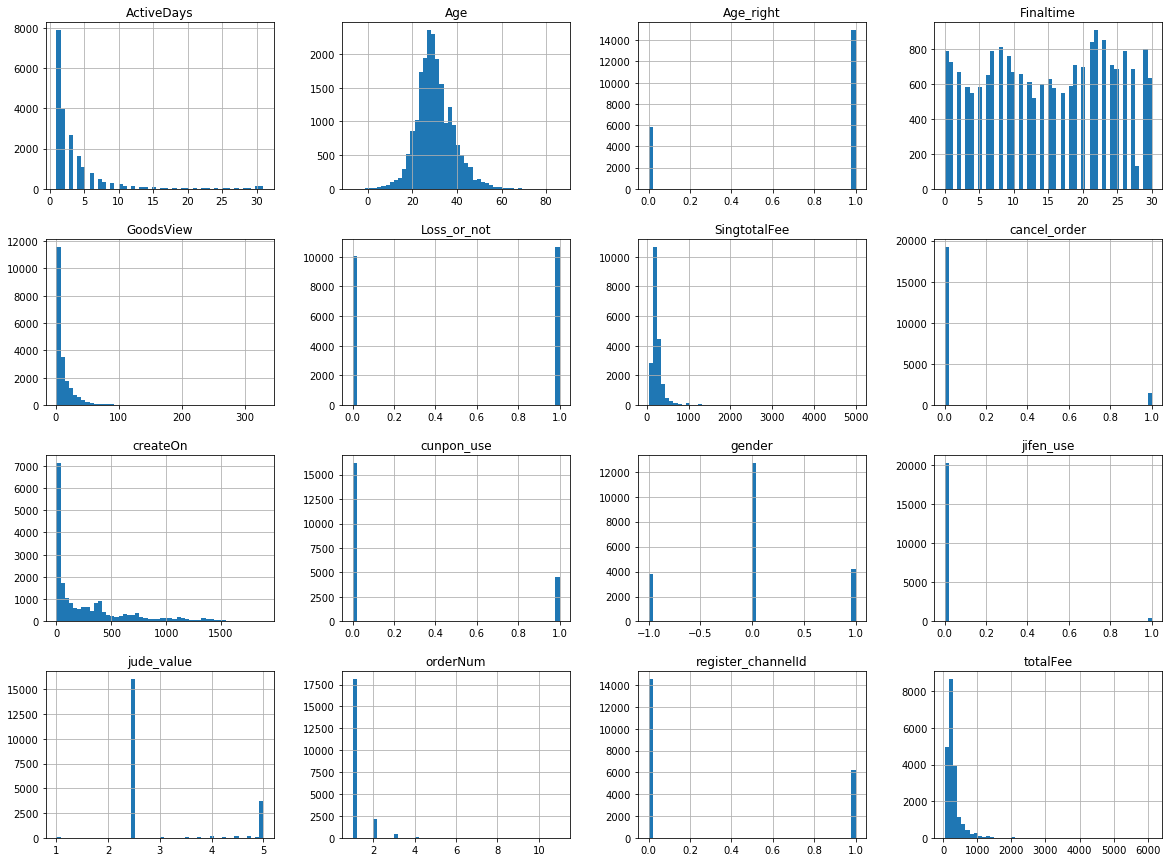

In [10]:
data_shuffle.hist(bins=50,figsize=(20,15))
plt.show()
# 已经将错误的年龄均匀的分布到各个年龄上面

In [11]:
# 将数据划分为训练集和测试集
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data_shuffle, data_shuffle['Loss_or_not']):
    strat_train_set = data_shuffle.loc[train_index]
    strat_test_set = data_shuffle.loc[test_index]

In [12]:
corr_matrix = data_shuffle.corr()
corr_matrix['Loss_or_not'].sort_values(ascending=False)

Loss_or_not           1.000000
Finaltime             0.180770
gender                0.077480
ActiveDays            0.049278
cunpon_use            0.047054
Age_right             0.036144
GoodsView             0.035710
cancel_order          0.030600
createOn              0.006088
jifen_use            -0.037229
SingtotalFee         -0.064009
Age                  -0.069536
totalFee             -0.078128
orderNum             -0.112980
jude_value           -0.124705
register_channelId   -0.285375
Name: Loss_or_not, dtype: float64

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


In [15]:
# Prepare data for machine learning
dating = strat_train_set.drop(['Loss_or_not'],1)
dating_labels = strat_train_set['Loss_or_not'].copy()

In [16]:
dating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16578 entries, 6571 to 20558
Data columns (total 16 columns):
provinceId            16578 non-null category
gender                16578 non-null int64
createOn              16578 non-null int64
orderNum              16578 non-null int64
Finaltime             16578 non-null int64
totalFee              16578 non-null float64
SingtotalFee          16578 non-null float64
jude_value            16578 non-null float64
register_channelId    16578 non-null int64
cunpon_use            16578 non-null int64
jifen_use             16578 non-null int64
cancel_order          16578 non-null int64
GoodsView             16578 non-null int64
ActiveDays            16578 non-null int64
Age                   16578 non-null float64
Age_right             16578 non-null int64
dtypes: category(1), float64(4), int64(11)
memory usage: 2.0 MB


In [17]:
num_attribute = ['createOn','orderNum','Finaltime','totalFee',
              'SingtotalFee','jude_value','GoodsView','ActiveDays','Age']
cat_attribute = ['provinceId','gender','register_channelId','cunpon_use',
               'jifen_use','cancel_order','Age_right']

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribute)),
    ('std_scaler',StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(['provinceId'])),
    ('label_binarizer',LabelBinarizer(sparse_output=True))
])
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
])


In [19]:
for i in range(7):
    dating[cat_attribute[i]] = dating[cat_attribute[i]].astype('category')

In [ ]:
#dating_num1 = num_pipeline.fit_transform(dating)
#dating_num1 = pd.DataFrame(dating_num1,columns=num_attribute)

In [ ]:
#dating_cat = dating[cat_attribute]
#dating_cat.info()

In [22]:
for i in range(7):
    dating[cat_attribute[i]] = dating[cat_attribute[i]].astype('category')

In [ ]:
#dating_prepared.info();dating_labels.count()

In [23]:
dating[num_attribute] = dating[num_attribute].apply(lambda x: (x-min(x))/(max(x)-min(x)))
dating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16578 entries, 6571 to 20558
Data columns (total 16 columns):
provinceId            16578 non-null category
gender                16578 non-null category
createOn              16578 non-null float64
orderNum              16578 non-null float64
Finaltime             16578 non-null float64
totalFee              16578 non-null float64
SingtotalFee          16578 non-null float64
jude_value            16578 non-null float64
register_channelId    16578 non-null category
cunpon_use            16578 non-null category
jifen_use             16578 non-null category
cancel_order          16578 non-null category
GoodsView             16578 non-null float64
ActiveDays            16578 non-null float64
Age                   16578 non-null float64
Age_right             16578 non-null category
dtypes: category(7), float64(9)
memory usage: 1.4 MB


### Training and Evaluating on the Training Set

### Better Evaluation Using Cross-Validation

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
# 接下来将测试3种算法 LR SVM ENSEMBLE 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [26]:
lg = LogisticRegression()
SVM = svm.SVC()
RFC = RandomForestClassifier()

In [29]:
def display_scores(scores):
    print('Mean: ',scores.mean())
    print('Standard deviation: ',scores.std())

In [30]:
# 先测试LR模型
scores_lg = cross_val_score(lg, dating, dating_labels,
                           scoring='neg_mean_squared_error',cv=10)
rmse_scores_lg = np.sqrt(-scores_lg)
display_scores(rmse_scores_lg)

Mean:  0.696621618698
Standard deviation:  8.73890386489e-05


In [33]:
# 再次测试SVM模型
scores_svm = cross_val_score(SVM, dating, dating_labels,
                           scoring='neg_mean_squared_error',cv=10)
rmse_scores_svm = np.sqrt(-scores_svm)
display_scores(rmse_scores_svm)

Mean:  0.588213649843
Standard deviation:  0.00832806050107


In [34]:
# 再次测试随机森林算法
scores_rfc = cross_val_score(RFC, dating, dating_labels,
                           scoring='neg_mean_squared_error',cv=10)
rmse_scores_rfc = np.sqrt(-scores_rfc)
display_scores(rmse_scores_rfc)

Mean:  0.51270808542
Standard deviation:  0.011484906129


### 调节模型的参数

In [48]:
#我们先来调节SVM模型的参数
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':[3,10,30,60,90]}
]


In [49]:
RFC_1 = RandomForestClassifier()
grid_search = GridSearchCV(RFC_1, param_grid,cv=5)
grid_search.fit(dating,dating_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 60, 90]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
grid_search.best_params_

{'n_estimators': 90}

In [51]:
dating_cat  = dating[cat_attribute]
dating_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16578 entries, 6571 to 20558
Data columns (total 7 columns):
provinceId            16578 non-null category
gender                16578 non-null category
register_channelId    16578 non-null category
cunpon_use            16578 non-null category
jifen_use             16578 non-null category
cancel_order          16578 non-null category
Age_right             16578 non-null category
dtypes: category(7)
memory usage: 243.2 KB


In [52]:
dating_cat = dating_cat.apply(LabelBinarizer().fit_transform)

Exception: Data must be 1-dimensional